In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from scipy.optimize import curve_fit

In [2]:
# Function definitions
def get_toa(f):
    chains = np.load(f)
    toa = np.zeros((chains.shape[-1] - 1) // 3)
    toa_err = np.zeros((chains.shape[-1] - 1) // 3)
    for i, chain in enumerate(chains.T):
        if (i % 3) == 1:
            toa[i // 3] = np.median(chain)
            toa_err[i // 3] = np.std(chain)
    return toa - toa.min(), toa_err

def get_power_spectrum(prof, dt):
    nbins = prof.size
    t = nbins * dt
    time = np.linspace(0, t, nbins)
    delta_f = 1./(nbins*dt)

    power_spectrum = np.abs(np.fft.fft(prof))**2
    power_spectrum = power_spectrum[:nbins//2]
    idx_max0 = np.nonzero(np.diff(power_spectrum) < 0)[0][0]
    idx_min = np.nonzero(np.diff(power_spectrum[idx_max0:]) > 0)[0][0] + idx_max0
    idx_max = np.argmax(power_spectrum[idx_min:]) + idx_min

    spectrum_norm = power_spectrum / power_spectrum[idx_max]
    f = np.arange(spectrum_norm.size)*delta_f
    f_max = f[idx_max]
    p0 = 1 / f_max

    plt.plot(f, spectrum_norm, 'k')
    plt.axvline(f_max, color='r', zorder=-1)
    plt.xlabel('Spin Frequency (kHz)')
    plt.ylabel('Power (norm.)')
    plt.title('Power Spectrum')
    plt.ylim(0, 1.1)
    plt.xlim(0, f[65])
    plt.show()
    return p0

def get_phases(toa, spin_period):
    p = (toa + spin_period / 2) % spin_period - spin_period / 2
    mean = np.sum(p / toa_err**2) / np.sum(1 / toa_err**2)
    return p - mean

def get_phases_centered(toa_err):
    return get_phases

def refine_period(toa, toa_err, spin_period):
    x = toa - toa.min()
    p = x % spin_period
    p = (p - p[0] + spin_period / 2) % spin_period
    q, m = P.polyfit(x, p, 1, w=1/toa_err)

    # Calculate new period
    popt, pcov = curve_fit(
        get_phases_centered(toa_err), 
        x, 
        np.zeros_like(toa), 
        p0 = [spin_period],
        sigma = toa_err,
        absolute_sigma = False,
    )
    period = popt[0]
    period_err = np.sqrt(np.diag(pcov))[0]

    p = get_phases_centered(toa_err)(x, period)
    q, m = P.polyfit(x, p + period / 2, 1, w=1/toa_err)

    # Chi2 reduced
    q = P.polyfit(x, p, 0, w=1/toa_err)
    red_chi2 = np.sum((p - q)**2 / toa_err**2) / (toa.size - 2)

    plt.errorbar(x, p, yerr=toa_err, fmt='k.')
    plt.axhline(0, color='k', ls=':')
    plt.plot(x, q + np.zeros_like(x), color='r')
    plt.xlabel('TOA (ms)')
    plt.ylabel(' Residuals (ms)')
    plt.ylim(-period/2, period/2)
    plt.show()
    
    print(f'Period = {period:.1f} +- {period_err:.1f} ms')
    print(f'Reduced Chi square = {red_chi2:.3f}')
    return period, period_err

def print_toa(toa, toa_err):
    print("ToAs (ms)")
    for t, te in zip(toa, toa_err):
        if te > 1:
            print(f"{t:.0f}({te:.0f})")
        else:
            f_t = int(np.ceil(-np.log10(te)))
            print(f"{t:.{f_t}f}({(te * 10**f_t):.0f})")

Event 65777546

ToAs (ms)
0(6)
430(9)
652(3)
1086.2(8)
1520(2)
1736(1)
1952(1)
2171(2)
2604(2)


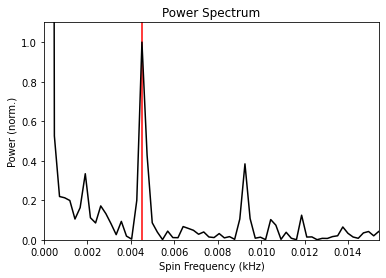

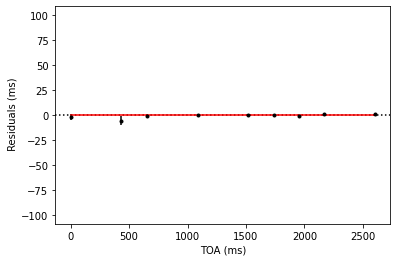

Period = 216.8 +- 0.1 ms
Reduced Chi square = 1.090

###############################

Event 156410110

ToAs (ms)
0.00(1)
2.221(5)
4.974(6)
8.358(8)
13.580(9)


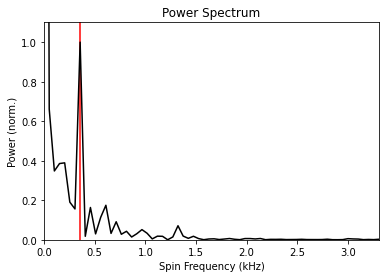

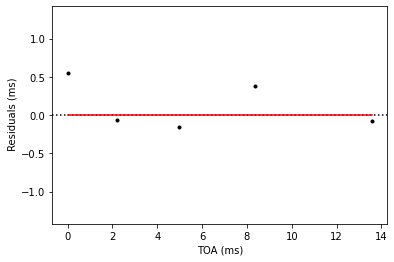

Period = 2.8 +- 0.1 ms
Reduced Chi square = 6261.136

###############################

Event 157646917

ToAs (ms)
0.00(5)
10.53(8)
21.70(3)
32.60(2)
44.4(1)
52.48(5)


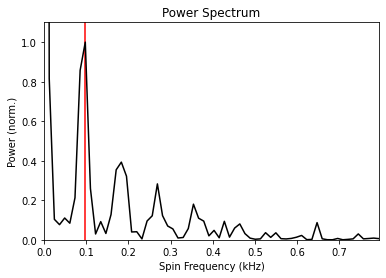

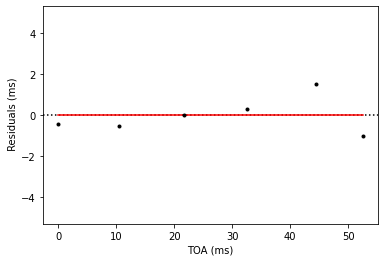

Period = 10.6 +- 0.2 ms
Reduced Chi square = 831.661

###############################



In [6]:
data_files = [
    'data/65777546_data.npz',
    'data/156410110_data.npz',
    'data/157646917_data.npz'
]
chain_files =[
    'data/65777546_mcmc_chains.npy',
    'data/156410110_mcmc_chains.npy',
    'data/157646917_mcmc_chains.npy'
]

for f_data, f_chain in zip(data_files, chain_files):
    print("Event", f_data[5:].split('_')[0])
    print()
    
    (
        _,
        prof,
        dt,
    ) = np.load(f_data).values()
    toa, toa_err = get_toa(f_chain)
    
    print_toa(toa, toa_err)

    p0 = get_power_spectrum(prof, dt)
    p, p_err = refine_period(toa, toa_err / 2, p0)
    
    print()
    print("###############################")
    print()